# Time Series Prediction with PyTorch

**XBUS-512: Introduction to AI and Deep Learning**

In this exercise, we will see how to build a time series model with PyTorch. 

*Note: This lab is inspired by [this blog post](https://www.curiousily.com/posts/time-series-forecasting-with-lstm-for-daily-coronavirus-cases/) by Venelin Valkov.*


In [1]:
import os
import torch
import requests
import numpy as np
import pandas as pd
from torch import nn, optim
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin

## Download the data

In [2]:
def fetch_data(url, fname):
    """
    Helper method to retreive data.
    """
    response = requests.get(url)
    outpath  = os.path.abspath(fname)
    with open(outpath, "wb") as f:
        f.write(response.content)
    
    return outpath

In [3]:
# Fetch the data

URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
FNAME = "confirmed_US_cases.csv"

fetch_data(URL, os.path.join("../fixtures", FNAME))

'/Users/rebeccabilbro/Desktop/eudicot/georgetown/intro-to-dl/fixtures/confirmed_US_cases.csv'

In [4]:
# Read into a dataframe
cumulative_cases = pd.read_csv(os.path.join("../fixtures", FNAME))
cumulative_cases.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,1065,1086,1169,1174,1162,1188,1196,1196,1206,1218
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,3443,3502,3544,3651,3670,3710,3744,3791,3839,3877
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,569,573,575,576,579,581,586,590,598,604
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,416,426,438,442,444,453,457,465,469,469
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,774,788,800,812,816,825,835,848,854,860


In [5]:
# Drop the non-numeric columns & all cases before April 1
cumulative_cases = cumulative_cases.iloc[:, 81:]

In [6]:
# Sum each column to get the daily cases
cumulative_daily_cases = cumulative_cases.sum(axis=0)
cumulative_daily_cases.index = pd.to_datetime(cumulative_daily_cases.index)
cumulative_daily_cases.head()

2020-04-01    214205
2020-04-02    244610
2020-04-03    276547
2020-04-04    309699
2020-04-05    337573
dtype: int64

<AxesSubplot:title={'center':'Cumulative daily cases'}>

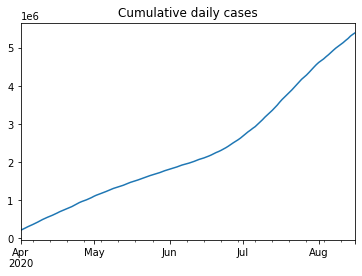

In [7]:
cumulative_daily_cases.plot(title="Cumulative daily cases")

In [8]:
# Use the diff() method to compute the differences to get daily new cases
# Pad the first day with the cases at t=1
daily_cases = cumulative_daily_cases.diff()
daily_cases[0] = daily_cases[1]
daily_cases.astype(np.int64)

daily_cases.head()

2020-04-01    30405.0
2020-04-02    30405.0
2020-04-03    31937.0
2020-04-04    33152.0
2020-04-05    27874.0
dtype: float64

<AxesSubplot:title={'center':'Daily cases'}>

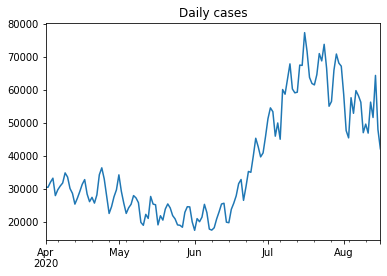

In [9]:
daily_cases.plot(title="Daily cases")

In [10]:
# Let's set our window size to 1 week
WINDOW = 7

# We'll set our training epochs to 500
EPOCHS = 500 # Hint: Change to 50 to run in class

# And we'll set aside 15% of the data for testing
TEST_RATIO = 0.15

In [11]:
class Sequencer(BaseEstimator, TransformerMixin):
    
    def __init__(self, window_size=WINDOW):
        self.window_size = window_size

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        """
        Take in data as a 1-dimensional sequence and tranform it into
        a multidimensional series of sequences of window_size, returning
        a tuple containing the features (the data points for each window) 
        and target (the subsequent value after each window) 
        for a time series prediction
        """
        X_t = []
        y_t = []

        window_count = len(X) - self.window_size - 1

        for window in range(window_count):
            X_t.append(X[window:(window + self.window_size)])
            y_t.append(X[window + self.window_size])

        return np.array(X_t), np.array(y_t)

In [12]:
# Scale the daily cases between 0 and 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(
    np.expand_dims(daily_cases, axis=1)
)

# Sequence them into 5-day windows
X, y = Sequencer().fit_transform(
    X_scaled
)

# Split the data
ratio = int(len(X) * TEST_RATIO)
X_train = X[: -ratio]
X_test = X[-ratio: ]
y_train = y[: -ratio]
y_test = y[-ratio: ]

# Convert to PyTorch tensors
X_train_t = torch.from_numpy(X_train).float()
X_test_t = torch.from_numpy(X_test).float()
y_train_t = torch.from_numpy(y_train).float()
y_test_t = torch.from_numpy(y_test).float()

In [13]:
class CoronaVirusPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        """
        Initialize all helper data and create the layers
        """
        super(CoronaVirusPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
            dropout=0.5
        )

        self.linear = nn.Linear(in_features=n_hidden, out_features=1)

    def reset_hidden_state(self):
        """
        Reset the state after each example
        """
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
        
    def forward(self, sequences):
        """
        Pass sequences through the LSTM layer
        Take the output of the last time step, 
        pass it through the linear layer to get the prediction.
        """
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(
            self.seq_len, len(sequences), self.n_hidden
        )[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [14]:
def train_model(model, X_train, y_train, X_test=None, y_test=None):
    loss_fn = torch.nn.MSELoss(reduction="sum")
    optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = EPOCHS

    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)

    for t in range(num_epochs):
        model.reset_hidden_state()

        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)

        if X_test is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
                test_hist[t] = test_loss.item()

            if t % 10 == 0:  
                print(
                    "Epoch {} train loss: {} test loss: {}".format(
                        t, loss.item(), test_loss.item()
                    )
                )

        elif t % 10 == 0:
            print("Epoch {} train loss: {}".format(t, loss.item()))

        train_hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
  
    return model.eval(), train_hist, test_hist

In [15]:
model = CoronaVirusPredictor(
    n_features=1, 
    n_hidden=512, 
    seq_len=WINDOW, 
    n_layers=2
)

model, train_hist, test_hist = train_model(
    model, 
    X_train_t,  
    y_train_t, 
    X_test_t,
    y_test_t
)

Epoch 0 train loss: 16.74263572692871 test loss: 7.920504570007324
Epoch 10 train loss: 8.21377182006836 test loss: 2.765519142150879
Epoch 20 train loss: 7.799892425537109 test loss: 3.017439842224121
Epoch 30 train loss: 7.621490955352783 test loss: 3.3906407356262207
Epoch 40 train loss: 5.595541000366211 test loss: 115.91047668457031
Epoch 50 train loss: 6.406832695007324 test loss: 0.7799493074417114
Epoch 60 train loss: 6.459224700927734 test loss: 0.48116469383239746
Epoch 70 train loss: 4.967972278594971 test loss: 92.25052642822266
Epoch 80 train loss: 4.086022853851318 test loss: 38.113712310791016
Epoch 90 train loss: 3.7708568572998047 test loss: 19.83019256591797
Epoch 100 train loss: 3.0331804752349854 test loss: 1.0502201318740845
Epoch 110 train loss: 3.029949426651001 test loss: 0.5957807898521423
Epoch 120 train loss: 2.9681708812713623 test loss: 0.41521531343460083
Epoch 130 train loss: 3.124047040939331 test loss: 0.3470664918422699
Epoch 140 train loss: 2.98633456

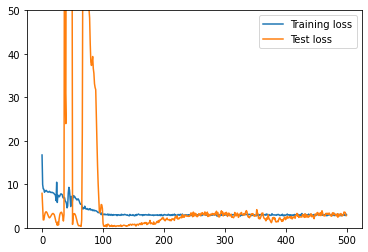

In [16]:
fig, ax = plt.subplots()

ax.plot(train_hist, label="Training loss")
ax.plot(test_hist, label="Test loss")
ax.set_ylim((0, 50))
ax.legend()

In [17]:
with torch.no_grad():
    test_seq = X_test_t[:1]
    preds = []
    for _ in range(len(X_test)):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, WINDOW, 1).float()

In [18]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test_t.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

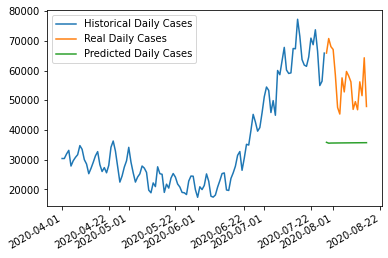

In [19]:
fig, ax = plt.subplots()

ax.plot(
    daily_cases.index[:len(X_scaled[: -ratio])], 
    scaler.inverse_transform(X_scaled[: -ratio]).flatten(),
    label="Historical Daily Cases"
)

ax.plot(
    daily_cases.index[len(X_scaled[: -ratio]):len(X_scaled[: -ratio]) + len(true_cases)], 
    true_cases,
    label="Real Daily Cases"
)

ax.plot(
    daily_cases.index[len(X_scaled[: -ratio]):len(X_scaled[: -ratio]) + len(true_cases)], 
    predicted_cases, 
    label="Predicted Daily Cases"
)

fig.autofmt_xdate()
ax.legend()

In [20]:
# Convert to PyTorch tensors (no train and test splits)
X_t = torch.from_numpy(X).float()
y_t = torch.from_numpy(y).float()

model = CoronaVirusPredictor(
    n_features=1, 
    n_hidden=512, 
    seq_len=WINDOW, 
    n_layers=2
)
model, train_hist, _ = train_model(model, X_t, y_t)

Epoch 0 train loss: 22.954971313476562
Epoch 10 train loss: 10.641324043273926
Epoch 20 train loss: 9.397419929504395
Epoch 30 train loss: 5.0224995613098145
Epoch 40 train loss: 3.301912784576416
Epoch 50 train loss: 2.918661594390869
Epoch 60 train loss: 2.8225090503692627
Epoch 70 train loss: 2.596653938293457
Epoch 80 train loss: 5.791833400726318
Epoch 90 train loss: 5.405145168304443
Epoch 100 train loss: 3.148092269897461
Epoch 110 train loss: 3.1211044788360596
Epoch 120 train loss: 2.884145736694336
Epoch 130 train loss: 2.6627554893493652
Epoch 140 train loss: 3.3462376594543457
Epoch 150 train loss: 6.40684175491333
Epoch 160 train loss: 3.9924774169921875
Epoch 170 train loss: 3.6578874588012695
Epoch 180 train loss: 3.1736152172088623
Epoch 190 train loss: 3.276475191116333
Epoch 200 train loss: 2.973306179046631
Epoch 210 train loss: 2.7227320671081543
Epoch 220 train loss: 2.566549777984619
Epoch 230 train loss: 2.979503631591797
Epoch 240 train loss: 3.6129860877990723


In [21]:
# Predict the next four weeks...
DAYS_TO_PREDICT = WINDOW * 4

with torch.no_grad():
    test_seq = X_t[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, WINDOW, 1).float()

In [22]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [23]:
daily_cases.index[-1]

Timestamp('2020-08-16 00:00:00')

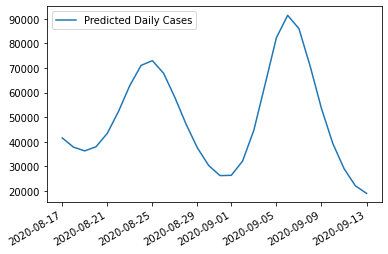

In [24]:
predicted_index = pd.date_range(
    start=daily_cases.index[-1],
    periods=DAYS_TO_PREDICT + 1,
    closed="right"
)

predicted_cases = pd.Series(
    data=predicted_cases,
    index=predicted_index
)

fig, ax = plt.subplots()
ax.plot(predicted_cases, label="Predicted Daily Cases")
fig.autofmt_xdate()
ax.legend()

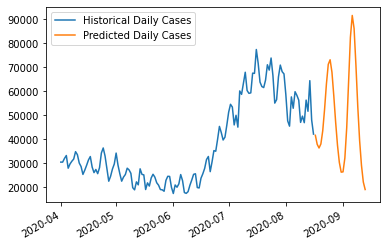

In [25]:
fig, ax = plt.subplots()
ax.plot(daily_cases, label="Historical Daily Cases")
ax.plot(predicted_cases, label="Predicted Daily Cases")
fig.autofmt_xdate()
ax.legend()